In [46]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import zipfile


In [47]:
!pip install tensorflow_hub --upgrade
import tensorflow_hub as hub

In [48]:
trained_MobileNet_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

# Get the pretrained Model

In [49]:
trained_MobileNet = tf.keras.Sequential([
    hub.KerasLayer(trained_MobileNet_url, input_shape=(224,224,3))
])

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
path = '/content/drive/MyDrive/Udemy/TensorFlow/Transfer-Learning-Data.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/drive/MyDrive/Udemy/TensorFlow/Transfer-Learning-Data.zip' mode='r'>>

In [52]:
sample_image = tf.keras.preprocessing.image.load_img(r'/content/Transfer Learning Data/watch.jpg', target_size=(224,224))

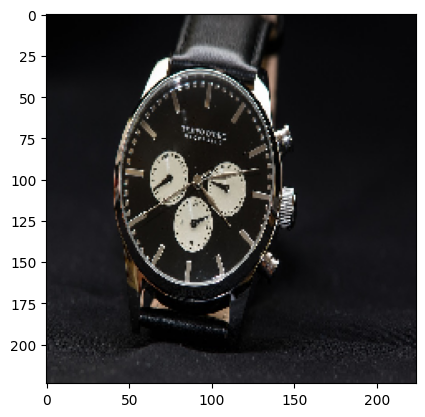

In [53]:
plt.imshow(sample_image)

In [54]:
sample_image = np.array(sample_image) / 255

In [55]:
sample_image.shape

(224, 224, 3)

In [56]:
predict_class = trained_MobileNet.predict(sample_image.reshape(1,224,224,3))

1/1 [==============================] - 4s 4s/step


In [57]:
predict_class

array([[ 0.31899288,  0.6976617 , -0.48101687, ...,  0.22585547,
        -1.4412357 , -0.0252165 ]], dtype=float32)

In [58]:
len(predict_class[0])

1001

In [59]:
predict_class.shape

(1, 1001)

In [60]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

In [61]:
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [62]:
imagenet_labels

array(['background', 'tench', 'goldfish', ..., 'bolete', 'ear',
       'toilet tissue'], dtype='<U30')

In [63]:
len(imagenet_labels)

1001

Text(0.5, 1.0, 'stopwatch')

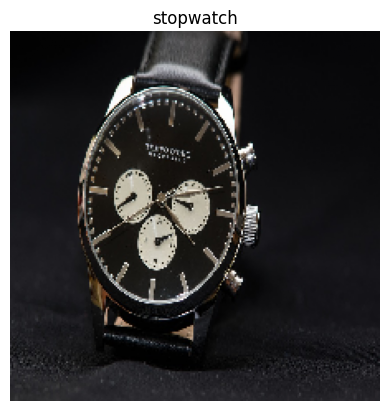

In [64]:
plt.imshow(sample_image)
plt.axis('off')
plt.title(imagenet_labels[predict_class.argmax()])

# Testing with Flowers dataset

In [65]:
flowers_data_url = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True
)

In [66]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
flowers_data = image_generator.flow_from_directory(str(flowers_data_url), target_size=(224,224), batch_size=64, shuffle = True)

Found 3670 images belonging to 5 classes.


# Checking the batch size

In [67]:
for flowers_data_input_batch, flowers_data_label_batch in flowers_data:
  print("Image batch shape: ", flowers_data_input_batch.shape)
  print("Label batch shape: ",flowers_data_label_batch.shape)
  break


Image batch shape:  (64, 224, 224, 3)
Label batch shape:  (64, 5)


# Testing

In [68]:
predictions_batch = trained_MobileNet.predict(flowers_data_input_batch)
predictions_batch.shape

2/2 [==============================] - 6s 3s/step


(64, 1001)

In [69]:
predicted_class_names = imagenet_labels[np.argmax(predictions_batch, axis=-1)]
predicted_class_names

array(['daisy', 'tractor', 'pot', 'picket fence', 'pot', 'daisy', 'pot',
       'bee', 'bee', 'horse cart', 'tarantula', 'sulphur butterfly',
       'bakery', 'palace', 'rapeseed', 'vase', 'cardoon', 'conch',
       'daisy', 'teddy', 'picket fence', 'daisy', 'daisy', 'daisy',
       'mushroom', 'cardoon', 'daisy', 'pot', 'plastic bag', 'daisy',
       'daisy', 'mushroom', 'daisy', 'daisy', 'daisy', 'sea anemone',
       'rapeseed', 'cardoon', 'daisy', 'admiral', 'daisy', 'daisy',
       'fountain', 'daisy', 'bee', 'hip', 'picket fence', 'bottlecap',
       'cardoon', 'coral fungus', 'daisy', 'feather boa', 'vase',
       'picket fence', 'daisy', 'ice lolly', 'daisy', 'daisy', 'ant',
       'cardoon', 'daisy', 'artichoke', 'buckeye', 'corn'], dtype='<U30')

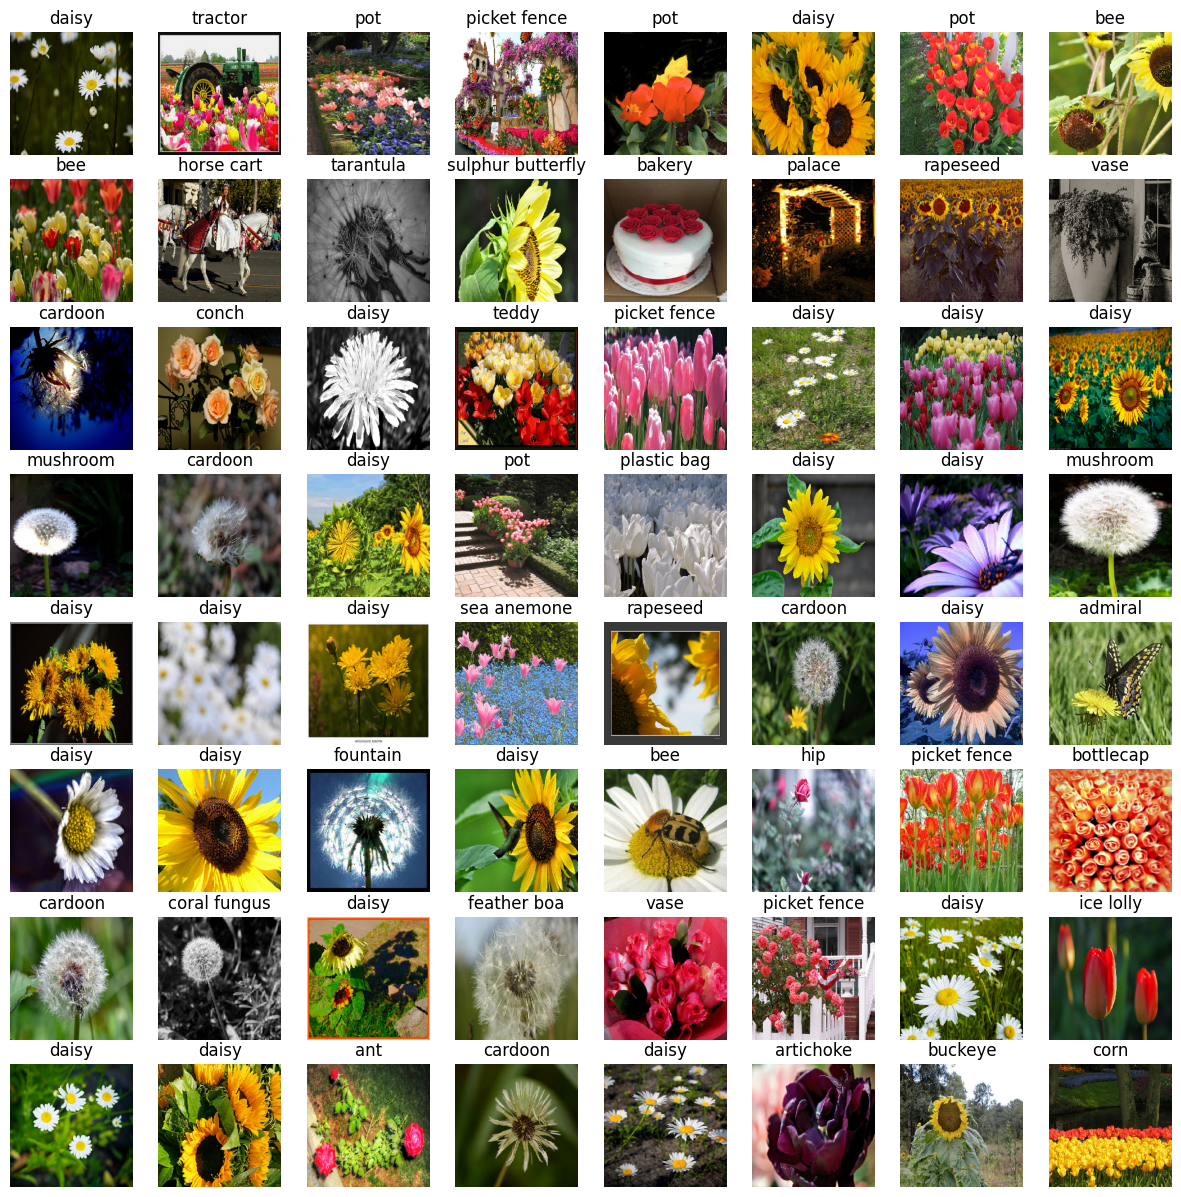

In [70]:
plt.figure(figsize=(15,15))
for n in range(64):
  plt.subplot(8,8,n+1)
  plt.imshow(flowers_data_input_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')

# Transfer Learning

In [71]:
MobileNet_feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

In [72]:
MobileNet_feature_extractor_layer = hub.KerasLayer(MobileNet_feature_extractor_url, input_shape=(224,224,3))

In [73]:
feature_batch = MobileNet_feature_extractor_layer(flowers_data_input_batch)
feature_batch.shape

TensorShape([64, 1280])

In [74]:
MobileNet_feature_extractor_layer.trainable = False

In [75]:
flowers_data.num_classes

5

In [76]:
model = tf.keras.Sequential([
    MobileNet_feature_extractor_layer,
    tf.keras.layers.Dense(flowers_data.num_classes,
    activation='softmax')
])

In [77]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [78]:
predictions = model(flowers_data_input_batch)
predictions.shape

TensorShape([64, 5])

In [79]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [80]:
history = model.fit(flowers_data, epochs=50)

Epoch 1/50
58/58 [==============================] - 174s 3s/step - loss: 0.8916 - accuracy: 0.6736
Epoch 2/50
58/58 [==============================] - 160s 3s/step - loss: 0.4083 - accuracy: 0.8708
Epoch 3/50
58/58 [==============================] - 162s 3s/step - loss: 0.3217 - accuracy: 0.9003
Epoch 4/50
58/58 [==============================] - 167s 3s/step - loss: 0.2772 - accuracy: 0.9166
Epoch 5/50
58/58 [==============================] - 162s 3s/step - loss: 0.2426 - accuracy: 0.9267
Epoch 6/50
58/58 [==============================] - 160s 3s/step - loss: 0.2162 - accuracy: 0.9371
Epoch 7/50
58/58 [==============================] - 162s 3s/step - loss: 0.1967 - accuracy: 0.9450
Epoch 8/50
58/58 [==============================] - 170s 3s/step - loss: 0.1809 - accuracy: 0.9485
Epoch 9/50
58/58 [==============================] - 161s 3s/step - loss: 0.1660 - accuracy: 0.9586
Epoch 10/50
58/58 [==============================] - 159s 3s/step - loss: 0.1533 - accuracy: 0.9586
Epoch 11/

# Model Assessment

In [98]:
class_names = sorted(flowers_data.class_indices.items(), key = lambda pair:pair[1])

In [99]:
class_names

[('daisy', 0),
 ('dandelion', 1),
 ('roses', 2),
 ('sunflowers', 3),
 ('tulips', 4)]

In [100]:
class_names = np.array([key.title() for key, value in class_names])

In [101]:
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [102]:
predicted_batch = model.predict(flowers_data_input_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

2/2 [==============================] - 2s 1s/step


In [103]:
predicted_id

array([0, 4, 4, 2, 4, 3, 4, 3, 4, 2, 1, 3, 2, 2, 3, 2, 1, 2, 1, 4, 4, 0,
       4, 3, 1, 1, 3, 4, 4, 3, 0, 1, 3, 0, 1, 4, 3, 1, 3, 1, 0, 3, 1, 3,
       0, 2, 4, 2, 1, 1, 3, 1, 2, 2, 0, 4, 0, 3, 2, 1, 0, 4, 3, 4])

In [104]:
predicted_label_batch

array(['Daisy', 'Tulips', 'Tulips', 'Roses', 'Tulips', 'Sunflowers',
       'Tulips', 'Sunflowers', 'Tulips', 'Roses', 'Dandelion',
       'Sunflowers', 'Roses', 'Roses', 'Sunflowers', 'Roses', 'Dandelion',
       'Roses', 'Dandelion', 'Tulips', 'Tulips', 'Daisy', 'Tulips',
       'Sunflowers', 'Dandelion', 'Dandelion', 'Sunflowers', 'Tulips',
       'Tulips', 'Sunflowers', 'Daisy', 'Dandelion', 'Sunflowers',
       'Daisy', 'Dandelion', 'Tulips', 'Sunflowers', 'Dandelion',
       'Sunflowers', 'Dandelion', 'Daisy', 'Sunflowers', 'Dandelion',
       'Sunflowers', 'Daisy', 'Roses', 'Tulips', 'Roses', 'Dandelion',
       'Dandelion', 'Sunflowers', 'Dandelion', 'Roses', 'Roses', 'Daisy',
       'Tulips', 'Daisy', 'Sunflowers', 'Roses', 'Dandelion', 'Daisy',
       'Tulips', 'Sunflowers', 'Tulips'], dtype='<U10')

In [105]:
label_id = np.argmax(flowers_data_label_batch, axis=-1)
label_id

array([0, 4, 4, 2, 4, 3, 4, 3, 4, 2, 1, 3, 2, 2, 3, 2, 1, 2, 1, 4, 4, 0,
       4, 3, 1, 1, 3, 4, 4, 3, 0, 1, 3, 0, 1, 4, 3, 1, 3, 1, 0, 3, 1, 3,
       0, 2, 4, 2, 1, 1, 3, 1, 2, 2, 0, 4, 0, 3, 2, 1, 0, 4, 3, 4])

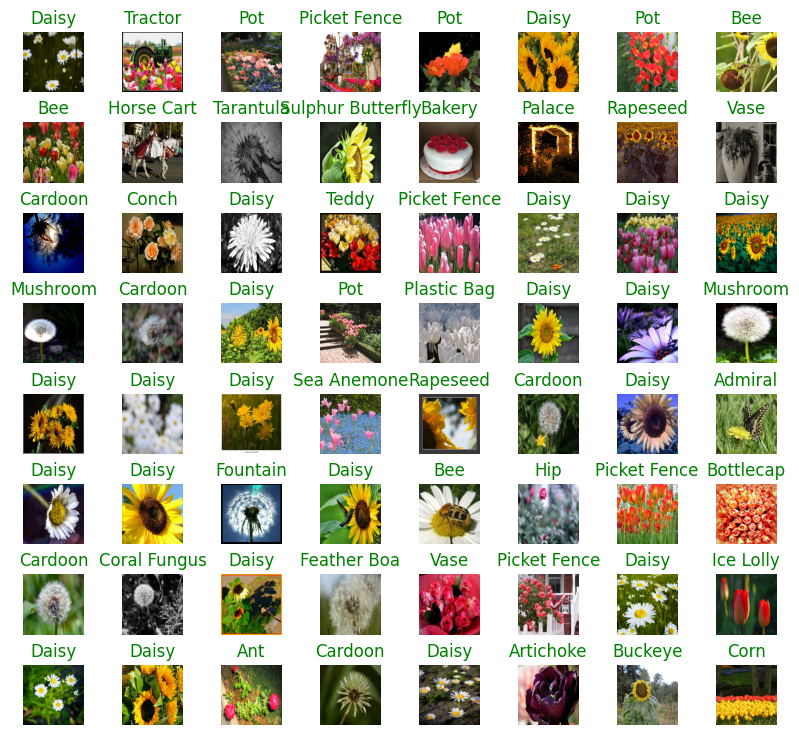

In [107]:
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)

for n in range(64):
  plt.subplot(8,8,n+1)
  plt.imshow(flowers_data_input_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_class_names[n].title(), color = color)
  plt.axis('off')